In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-11-02 17:56:08--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.15.193.111, 52.217.126.56, 54.231.194.128, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.15.193.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

jena_climate_2009_2 100%[===================>]  12.94M  15.9MB/s    in 0.8s    

2024-11-02 17:56:10 (15.9 MB/s) - ‘jena_climate_2009_2016.csv.zip.1’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
data = os.path.join("jena_climate_2009_2016.csv")

In [ ]:
with open(data) as f:
    data = f.read()

In [ ]:
records = data.split("\n")
title = records[0].split(",")
records = records[1:]
print(title)
print(len(records))
import os
data = os.path.join("jena_climate_2009_2016.csv")

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [ ]:
with open(data) as f:
    data = f.read()

In [ ]:
records = data.split("\n")
title = records[0].split(",")
records = records[1:]
print(title)
print(len(records))
#Processing and analyzing the data.


['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [ ]:
import numpy as np
temp = np.zeros((len(records),))
original_data = np.zeros((len(records), len(title) - 1))
for i, line in enumerate(records):
    values = [float(x) for x in line.split(",")[1:]]
    temp[i] = values[1]
    original_data[i, :] = values[:]
import numpy as np
temp = np.zeros((len(records),))
original_data = np.zeros((len(records), len(title) - 1))
for i, line in enumerate(records):
    values = [float(x) for x in line.split(",")[1:]]
    temp[i] = values[1]
    original_data[i, :] = values[:]
#Visualizing the temperature time series data.

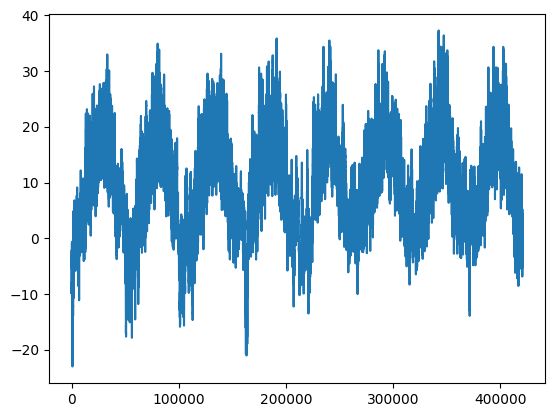

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temp)), temp)
#Visualizing the temperature time series for the first 10 days.

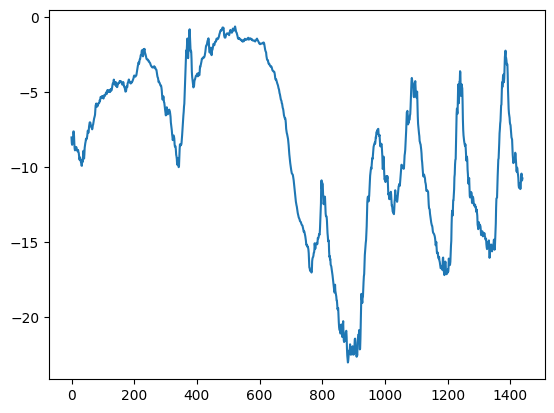

In [ ]:
plt.plot(range(1440), temp[:1440])
#Calculating the number of samples for each data split.

In [ ]:
train_Sample_Num = int(0.5 * len(original_data))
val_original_data = int(0.25 * len(original_data))
test_Sample_Number = len(original_data) - train_Sample_Num - val_original_data
print("train_Sample_Num:", train_Sample_Num)
print("val_original_data:", val_original_data)
print("test_Sample_Number:", test_Sample_Number)
#Data Preparation
#Normalizing the data

train_Sample_Num: 210225
val_original_data: 105112
test_Sample_Number: 105114


In [ ]:
mean = original_data[:train_Sample_Num].mean(axis=0)
original_data -= mean
std = original_data[:train_Sample_Num].std(axis=0)
original_data /= std
import numpy as np
from tensorflow import keras
num_series = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=num_series[:-3],
    targets=num_series[3:],
    sequence_length=3,
    batch_size=2,
)

In [ ]:
for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))
#Instantiating datasets for training, validation, and testing

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [ ]:
sample_rate = 6
seq_len = 120
delay = sample_rate * (seq_len + 24 - 1)
batch_size = 256

In [ ]:
train_dataset = keras.utils.timeseries_dataset_from_array(
    original_data[:-delay],
    targets=temp[delay:],
    sampling_rate=sample_rate,
    sequence_length=seq_len,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=train_Sample_Num)

In [ ]:
val_dataset = keras.utils.timeseries_dataset_from_array(
    original_data[:-delay],
    targets=temp[delay:],
    sampling_rate=sample_rate,
    sequence_length=seq_len,
    shuffle=True,
    batch_size=batch_size,
    start_index=train_Sample_Num,
    end_index=train_Sample_Num + val_original_data)

In [ ]:
test_dataset = keras.utils.timeseries_dataset_from_array(
    original_data[:-delay],
    targets=temp[delay:],
    sampling_rate=sample_rate,
    sequence_length=seq_len,
    shuffle=True,
    batch_size=batch_size,
    start_index=train_Sample_Num + val_original_data)
#Examining the results of one of our datasets to assess its content and quality.

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break
#A common-sense, non-machine-learning baseline
#Computing the common-sense baseline MAE

samples shape: (256, 120, 14)
targets shape: (256,)


In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

In [ ]:
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")


Validation MAE: 2.44
Test MAE: 2.62


In [ ]:
!pip install tensorflow==2.12

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 106.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 9.8 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    U

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(seq_len, original_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
#Visualizing the outcomes

Epoch 1/10
819/819 [==============================] - 50s 60ms/step - loss: 12.4799 - mae: 2.7373 - val_loss: 10.7508 - val_mae: 2.5898
Epoch 2/10
819/819 [==============================] - 41s 50ms/step - loss: 8.4837 - mae: 2.2881 - val_loss: 18.1040 - val_mae: 3.4506
Epoch 3/10
819/819 [==============================] - 40s 49ms/step - loss: 7.3690 - mae: 2.1315 - val_loss: 10.4222 - val_mae: 2.5369
Epoch 4/10
819/819 [==============================] - 40s 48ms/step - loss: 6.6881 - mae: 2.0342 - val_loss: 11.1361 - val_mae: 2.6322
Epoch 5/10
819/819 [==============================] - 50s 60ms/step - loss: 6.1876 - mae: 1.9571 - val_loss: 11.2733 - val_mae: 2.6297
Epoch 6/10
819/819 [==============================] - 39s 48ms/step - loss: 5.8093 - mae: 1.8973 - val_loss: 10.6586 - val_mae: 2.5737
Epoch 7/10
266/819 [========>.....................] - ETA: 19s - loss: 5.5985 - mae: 1.8666

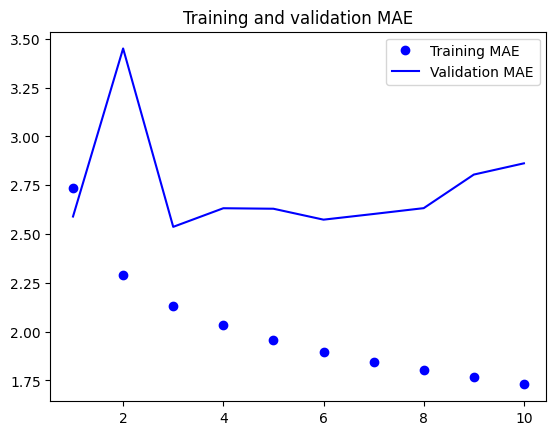

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()
#Let's try a 1D convolutional model
inputs = keras.Input(shape=(seq_len, original_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 72s 86ms/step - loss: 22.7385 - mae: 3.7573 - val_loss: 16.7449 - val_mae: 3.2814
Epoch 2/10
819/819 [==============================] - 70s 85ms/step - loss: 15.4664 - mae: 3.1137 - val_loss: 15.1685 - val_mae: 3.0721
Epoch 3/10
819/819 [==============================] - 70s 85ms/step - loss: 13.9005 - mae: 2.9479 - val_loss: 16.0622 - val_mae: 3.1878
Epoch 4/10
819/819 [==============================] - 70s 85ms/step - loss: 13.1099 - mae: 2.8575 - val_loss: 15.2492 - val_mae: 3.0770
Epoch 5/10
819/819 [==============================] - 74s 90ms/step - loss: 12.5349 - mae: 2.7950 - val_loss: 14.8536 - val_mae: 3.0362
Epoch 6/10
819/819 [==============================] - 72s 88ms/step - loss: 12.0707 - mae: 2.7415 - val_loss: 15.7266 - val_mae: 3.1443
Epoch 7/10
819/819 [==============================] - 77s 94ms/step - loss: 11.6463 - mae: 2.6940 - val_loss: 14.4444 - val_mae: 2.9917
Epoch 8/10
819/819 [============================

In [ ]:
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
#Establishing an initial recurrent model as a baseline.
#A simple LSTM-based model

405/405 [==============================] - 16s 39ms/step - loss: 15.1933 - mae: 3.0703
Test MAE: 3.07


In [ ]:
inputs = keras.Input(shape=(seq_len, original_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 92s 108ms/step - loss: 40.4353 - mae: 4.6066 - val_loss: 12.2261 - val_mae: 2.6703
Epoch 2/10
819/819 [==============================] - 87s 105ms/step - loss: 10.7716 - mae: 2.5477 - val_loss: 9.9214 - val_mae: 2.4666
Epoch 3/10
819/819 [==============================] - 86s 104ms/step - loss: 9.7521 - mae: 2.4296 - val_loss: 10.1326 - val_mae: 2.4827
Epoch 4/10
819/819 [==============================] - 88s 107ms/step - loss: 9.3576 - mae: 2.3810 - val_loss: 10.5231 - val_mae: 2.5204
Epoch 5/10
819/819 [==============================] - 86s 105ms/step - loss: 9.0289 - mae: 2.3432 - val_loss: 10.0320 - val_mae: 2.4823
Epoch 6/10
819/819 [==============================] - 91s 110ms/step - loss: 8.7527 - mae: 2.3050 - val_loss: 10.2453 - val_mae: 2.4994
Epoch 7/10
819/819 [==============================] - 87s 106ms/step - loss: 8.5766 - mae: 2.2827 - val_loss: 10.4450 - val_mae: 2.5226
Epoch 8/10
819/819 [===========================

In [ ]:
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
#Understanding recurrent neural networks
#NumPy implementation of a simple RNN

405/405 [==============================] - 21s 50ms/step - loss: 11.1081 - mae: 2.6287
Test MAE: 2.63


In [ ]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)
#A recurrent layer in Keras
#An RNN layer that can process sequences of any length

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)
#An RNN layer that returns only its last output step

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)
#An RNN layer that returns its full output sequence

(None, 16)


In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)
#Stacking RNN layers

(None, 120, 16)


In [ ]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
#Exploring advanced techniques with recurrent neural networks
#Applying recurrent dropout to combat overfitting
#Training and assessing an LSTM model with dropout regularization

In [ ]:
inputs = keras.Input(shape=(seq_len, original_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
inputs = keras.Input(shape=(seq_len, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

Epoch 1/10
819/819 [==============================] - 195s 236ms/step - loss: 28.3857 - mae: 3.9216 - val_loss: 9.6649 - val_mae: 2.4114
Epoch 2/10
819/819 [==============================] - 188s 229ms/step - loss: 14.7725 - mae: 2.9796 - val_loss: 9.6946 - val_mae: 2.4079
Epoch 3/10
819/819 [==============================] - 185s 225ms/step - loss: 13.8027 - mae: 2.8872 - val_loss: 9.1548 - val_mae: 2.3474
Epoch 4/10
819/819 [==============================] - 183s 223ms/step - loss: 13.2756 - mae: 2.8263 - val_loss: 8.9818 - val_mae: 2.3334
Epoch 5/10
819/819 [==============================] - 186s 227ms/step - loss: 12.7817 - mae: 2.7741 - val_loss: 9.0516 - val_mae: 2.3445
Epoch 6/10
819/819 [==============================] - 202s 246ms/step - loss: 12.4087 - mae: 2.7311 - val_loss: 8.9718 - val_mae: 2.3278
Epoch 7/10
819/819 [==============================] - 188s 229ms/step - loss: 12.0673 - mae: 2.6935 - val_loss: 9.0521 - val_mae: 2.3351
Epoch 8/10
819/819 [=====================

In [ ]:
inputs = keras.Input(shape=(seq_len, original_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)